<a href="https://colab.research.google.com/github/robinacharya/Ensemble-Machine-Learning-Algorithms-for-Real-World-Data-RWD-/blob/XGBM/XGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# XGBM Classification

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset from Google Drive
path_to_dataset = "/content/drive/MyDrive/german_credit_data.csv"
df = pd.read_csv(path_to_dataset)

In [4]:
# Display the first few rows of the dataset to understand its structure
print(df.head())

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad  


In [5]:
# Encode categorical variables if necessary
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [6]:
# Define features and target variable
X = df.drop(columns=['Risk'])
y = df['Risk']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Initialize the baseline XGBoost model
baseline_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
baseline_xgb.fit(X_train, y_train)

# Predict on the test set using the baseline model
y_pred_baseline = baseline_xgb.predict(X_test)
y_prob_baseline = baseline_xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
# Evaluate the performance of the baseline model
print("Baseline XGB Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

Baseline XGB Model Performance
Accuracy: 0.77
Confusion Matrix:
 [[ 29  30]
 [ 16 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.49      0.56        59
           1       0.81      0.89      0.84       141

    accuracy                           0.77       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200



In [9]:
# Compute ROC curve and ROC area for baseline model
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_prob_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV with the XGBoost Classifier
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best estimator
best_xgb = grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best Parameters Found by GridSearchCV:\n", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters Found by GridSearchCV:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [10]:
# Train the best estimator with the training data
best_xgb.fit(X_train, y_train)

# Predict on the test set using the tuned model
y_pred_tuned = best_xgb.predict(X_test)
y_prob_tuned = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate the performance of the tuned model
print("Tuned XGB Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned XGB Model Performance
Accuracy: 0.755
Confusion Matrix:
 [[ 28  31]
 [ 18 123]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.47      0.53        59
           1       0.80      0.87      0.83       141

    accuracy                           0.76       200
   macro avg       0.70      0.67      0.68       200
weighted avg       0.74      0.76      0.75       200



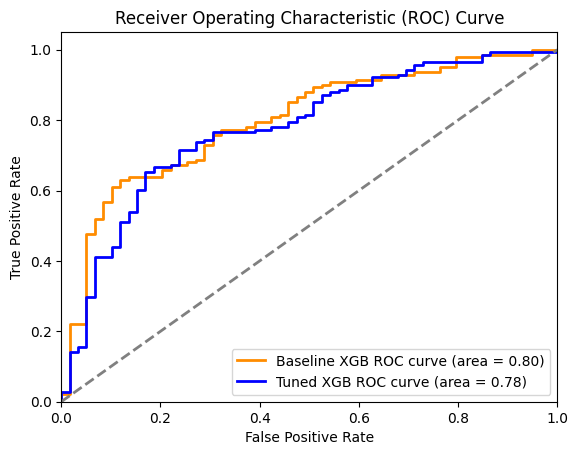

In [11]:
# Compute ROC curve and ROC area for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plotting the ROC curves
plt.figure()
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=2, label='Baseline XGB ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot(fpr_tuned, tpr_tuned, color='blue', lw=2, label='Tuned XGB ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()